In [5]:
import optuna
from train_GMM import get_points_in_box
import tensorflow as tf
import sys
sys.path.append("../../DMAE")
sys.path.append("../../DMAE/examples/synthetic")
import DMAE
import vis_utils
import itertools
import numpy as np
import matplotlib.pyplot as plt

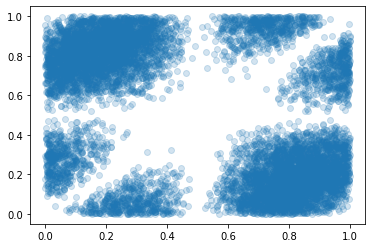

In [6]:
X = np.load("particle_positions_N=3_metro_steps=1000000_last_fixed.npz").T
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx][:10000]
X = get_points_in_box(X, 1)

X = np.float32(X[:, :2])
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)

In [7]:
# Number of clusters
n_clusters = 2

In [3]:
mystudy = optuna.study.load_study(study_name='dmae_opt_test', storage="sqlite:///dmae_opt_test.db")

In [8]:
bparams = mystudy.best_params

In [9]:
alpha = bparams['alpha']
batch_size = bparams['batch_size']
epochs = bparams['epochs']
lr = bparams['lr']

In [10]:
tf.random.set_seed(0)

def toroidal_dis(x_i, Y, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((x_i-Y+delta)**2, axis=1), d)
    return d

def toroidal_pairwise(X, Y, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_dis(x_i, Y, interval)
    Z = tf.vectorized_map(func, X)
    return Z

def toroidal_loss(X, mu_tilde, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((X-mu_tilde+delta)**2, axis=1), d)
    return d

In [11]:
interval = tf.constant((1.0, 1.0))
dis = lambda X, Y: toroidal_pairwise(X, Y, interval)
dmae_loss = lambda X, mu_tilde: toroidal_loss(X, mu_tilde, interval)

inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoder(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitPlusPlus(X, n_clusters, dis, 1),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": False},
                                                          dissimilarity=dis)(inp)
# DMAE model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
model.compile(loss=dmae_loss, optimizer=tf.optimizers.Adam(lr=lr))
history = model.fit(X, X, epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=0)
loss_circular = history.history['loss'][-1]

def toroidal_mahalanobis(x_i, Y, cov, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(x_i-Y+delta, axis=-1)
        d = tf.minimum(tf.squeeze(tf.reduce_sum(tf.matmul(cov, diff)*diff, axis=1)), d)
    return d

def toroidal_mahalanobis_pairwise(X, Y, cov, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_mahalanobis(x_i, Y, cov, interval)
    Z = tf.vectorized_map(func, X)
    return Z

def toroidal_mahalanobis_loss(X, mu_tilde, Cov_tilde, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(X-mu_tilde+delta, axis=1)
        d = tf.minimum(tf.squeeze(tf.matmul(tf.matmul(diff, Cov_tilde), tf.transpose(diff, perm = [0, 2, 1]))), d)
    return d

interval = tf.constant((1.0, 1.0))
dis = lambda X, Y, cov: toroidal_mahalanobis_pairwise(X, Y, cov, interval)
dmae_loss = lambda X, mu_tilde, Cov_tilde: toroidal_mahalanobis_loss(X, mu_tilde, Cov_tilde, interval)

inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha=alpha, n_clusters=n_clusters,
                                                             initializers={"centers": tf.keras.initializers.RandomUniform(0, 1),
                                                                           "cov": DMAE.Initializers.InitIdentityCov(X, n_clusters),
                                                                           "mixers": tf.keras.initializers.Constant(1.0)},
                                                             trainable = {"centers": True, "mixers": False, "cov": True},
                                                             dissimilarity=dis)(inp)
# DMAE model
model2 = tf.keras.Model(inputs=[inp], outputs=theta_tilde)

loss = dmae_loss(inp, *theta_tilde)
model2.add_loss(loss)
model2.compile(optimizer=tf.optimizers.Adam(lr=lr))

init_means = model.layers[-1].get_weights()[0]
original_params = model2.layers[1].get_weights()
model2.layers[1].set_weights([init_means, *original_params[1:]])

history = model2.fit(X, epochs=epochs, batch_size=batch_size, callbacks=[callback], verbose=False)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [12]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(alpha=alpha, n_clusters=n_clusters,
                                                     dissimilarity=dis,
                                                     trainable={"centers": False, "mixers": False, "cov": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model2.layers[1].get_weights())

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(0.0, 1.0)

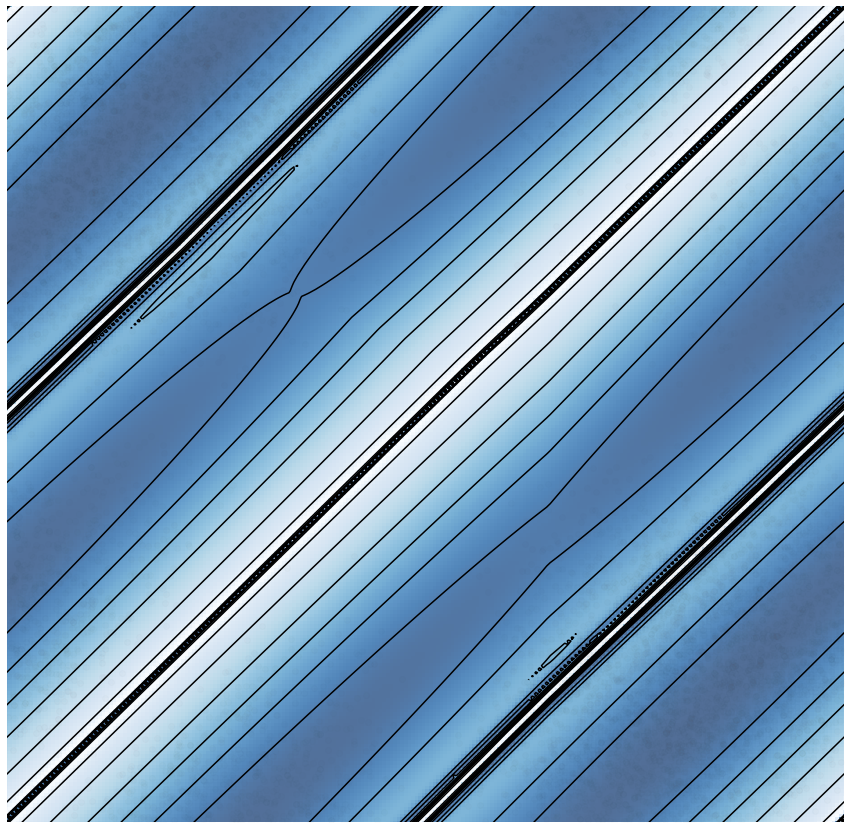

In [13]:
fig, ax = vis_utils.visualize_distribution(model2, dmae_loss, 50, X, figsize=(15, 15), cov=True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

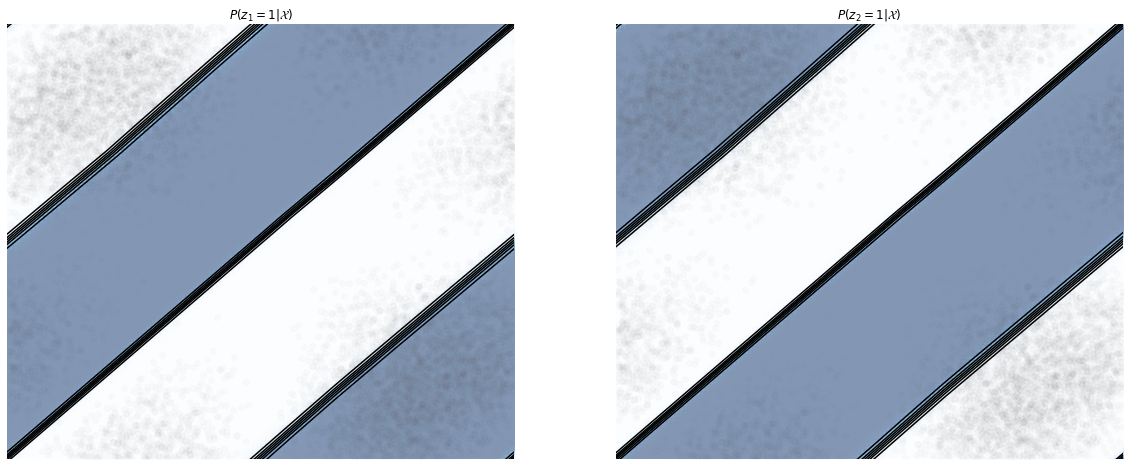

In [14]:
fig, ax = vis_utils.visualize_probas(DMAE_encoder, X, n_clusters, rows=1, cols=2, figsize=(20, 8))
for axi in ax:
    axi.set_xlim([0, 1])
    axi.set_ylim([0, 1])